In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
from sklearn.model_selection import train_test_split
import time
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
import gc
import skimage.transform

In [2]:
# test if GPUs are available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set project root, maybe you need to firstly 
# add shortcut of CS 766 Project to drive.
project_root = './drive/MyDrive/CS 766 Project/Project Coding and Data Files/'

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
            rotation_range=20,
            width_shift_range=0.1,  
            height_shift_range=0.1,    
            shear_range=0.1,        
            zoom_range=0.1,        
            horizontal_flip=True,         
            fill_mode='constant', cval=0,
            channel_shift_range=20,
            brightness_range=[0.5,1.5]
            )
all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Xtrain", "04_Only_Color_Processed_Xtrain_Batch%d_even.npy" % 0))
x = all_images[0]
x = x * 255
x = x.astype('uint8')
# x = io.imread(os.path.join(project_root, "Raw Data", "resized_train_cropped", "13_left.jpeg"))
x = x.reshape((1, ) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir=os.path.join(project_root, 'augmented'),
                          save_prefix='aug',
                          save_format='jpeg'):    
  i += 1    
  if i > 20:        
     break

255
uint8


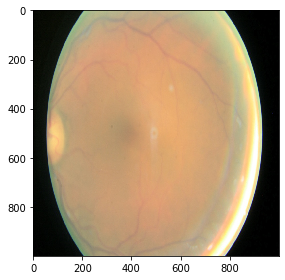

In [19]:
all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Xtrain", "04_Only_Color_Processed_Xtrain_Batch%d_even.npy" % 0))
# img = io.imread(os.path.join(project_root, "augmented", "aug_0_244.jpeg"))
# img = img * 255
img = all_images[0] * 255
img = img.astype('uint8')
print(img.max())
print(img.dtype)
io.imshow(img)

In [ ]:
# class to initialize CNNs
class OriginCNN(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    # self.optimizer = tf.keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
    # self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties


  def build(self):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu', input_shape=(1000, 1000, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), strides=(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(5))

    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1)
    return self.history

  def train_on_batch(self, train_images, train_labels):
    return self.model.train_on_batch(train_images, train_labels)

  def predict(self, test_images):
    return self.model.predict(test_images)


  def evaluate(self, test_images, test_labels):
    _, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)
    return test_images.shape[0], test_acc

  def save_model(self, filepath):
    self.model.save(filepath)

  def load_model(self, filepath):
    self.model = tf.keras.models.load_model(filepath)

  def extract_feature(self, images):
    extract = models.Model(self.model.inputs, self.model.layers[-3].output)
    return extract.predict(images)

In [ ]:
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
class Res50(object):
  """docstring for OriginCNN"""
  def __init__(self):
    self.optimizer = 'adam'
    # self.optimizer = tf.keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
    # self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # will add more properties


  def build(self):
    base_model = InceptionV3(
      include_top=False,
      weights="imagenet",
      input_shape=(224, 224, 3)
    )

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    # and a logistic layer -- let's say we have n classes
    predictions = Dense(2)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)


    model.summary()
    model.compile(optimizer=self.optimizer,
                loss=self.loss,
                metrics=['accuracy'])
    self.model = model


  def train(self, train_images, train_labels, epochs):
    self.history = self.model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1)
    return self.history

  def train_on_batch(self, train_images, train_labels):
    return self.model.train_on_batch(train_images, train_labels)

  def predict(self, test_images):
    return self.model.predict(test_images)


  def evaluate(self, test_images, test_labels):
    _, test_acc = self.model.evaluate(test_images, test_labels, verbose=2)
    return test_images.shape[0], test_acc

  def save_model(self, filepath):
    self.model.save(filepath)

  def load_model(self, filepath):
    self.model = tf.keras.models.load_model(filepath)

  def extract_feature(self, images):
    extract = models.Model(self.model.inputs, self.model.layers[-2].output)
    return extract.predict(images)

In [ ]:
class DR_resized(object):
  """docstring for DR_resized"""
  def __init__(self, is_training, batch_id, batch_size, train_val_split_rate, size=None):
    self.batch_size = batch_size
    self.train_val_split_rate = train_val_split_rate
    if(is_training):
      # load images
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Stratified_Random_Sampling_Datasets", "Processed_Xtrain_Batch%d.npy" % batch_id))
      all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Even_Class_Distribution_Datasets", "Processed_Xtrain_Batch%d_even.npy" % batch_id))
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Color_Even_Class_Distribution_Datasets", "Color_Processed_Xtrain_Batch%d_even.npy" % batch_id))
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Xtrain", "04_Only_Color_Processed_Xtrain_Batch%d_even.npy" % batch_id))
      
      # add a dimension for channels if gray scale images
      if (len(all_images[0].shape) == 2):
        all_images = np.expand_dims(all_images, axis=-1)

      # resize
      # gray scale
      if(size):
        if (len(all_images[0].shape) == 2):
          all_images_resize = np.zeros((all_images.shape[0], size[0], size[1], 1));
          for i in range(all_images.shape[0]):
            all_images_resize[i] = skimage.transform.resize(all_images[i].astype('float64'), (size[0], size[1]));
        # color image
        else:
          all_images_resize = np.zeros((all_images.shape[0], size[0], size[1], 3));
          for i in range(all_images.shape[0]):
            all_images_resize[i] = skimage.transform.resize(all_images[i].astype('float64'), (size[0], size[1]));
        all_images = all_images_resize


      # load labels
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Stratified Random Sampling Datasets", "Ytrain", "Ytrain_Batch%d.npy" % batch_id), allow_pickle=True)
      all_labels = np.load(os.path.join(project_root, "Data Batches", "Even Class Distribution Datasets", "Ytrain", "Ytrain_Batch%d_even.npy" % batch_id), allow_pickle=True)
      # all_labels = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Ytrain", "04_Only_Ytrain_Batch%d_even.npy" % batch_id), allow_pickle=True)
      all_labels = np.array([item[1] for item in all_labels])
      
      # one hot
      # all_labels_one_hot = np.zeros((all_labels.size, 5))
      # all_labels_one_hot[np.arange(all_labels.size),all_labels] = 1

      # without one hot
      all_labels_one_hot = np.expand_dims(all_labels, axis=-1)

      # shuffle
      np.random.seed(0);
      indices = np.arange(all_images.shape[0])
      np.random.shuffle(indices)
      all_images = all_images[indices]
      all_labels_one_hot = all_labels_one_hot[indices]

      self.train_images = all_images
      self.train_labels = all_labels_one_hot
    
    else:
      # load images
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Stratified_Random_Sampling_Datasets", "Processed_Xtest_Batch%d.npy") % batch_id)
      all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Even_Class_Distribution_Datasets", "Processed_Xest_Batch%d_even.npy") % batch_id)
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Color_Even_Class_Distribution_Datasets", "Color_Processed_Xest_Batch%d_even.npy") % batch_id)
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Xest", "04_Only_Color_Processed_Xest_Batch%d_even.npy" % batch_id))
      
      # add a dimension for channels if gray scale images
      if (len(all_images[0].shape) == 2):
        all_images = np.expand_dims(all_images, axis=-1)

      # resize
      if(size):
        # gray scale
        if (len(all_images[0].shape) == 2):
          all_images_resize = np.zeros((all_images.shape[0], size[0], size[1], 1));
          for i in range(all_images.shape[0]):
            all_images_resize[i] = skimage.transform.resize(all_images[i].astype('float64'), (size[0], size[1]));
        # color image
        else:
          all_images_resize = np.zeros((all_images.shape[0], size[0], size[1], 3));
          for i in range(all_images.shape[0]):
            all_images_resize[i] = skimage.transform.resize(all_images[i].astype('float64'), (size[0], size[1]));
        all_images = all_images_resize


      # load labels
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Stratified Random Sampling Datasets", "Ytest", "Ytest_Batch%d.npy" % batch_id), allow_pickle=True)
      all_labels = np.load(os.path.join(project_root, "Data Batches", "Even Class Distribution Datasets", "Ytest", "Yest_Batch%d_even.npy" % batch_id), allow_pickle=True)
      # all_labels = np.load(os.path.join(project_root, "Processed_Data_Batches", "04_Only_Color_Even_Class_Distribution_Datasets", "Yest", "04_Only_Yest_Batch%d_even.npy" % batch_id), allow_pickle=True)
      all_labels = np.array([item[1] for item in all_labels])

      # one hot
      # all_labels_one_hot = np.zeros((all_labels.size, 5))
      # all_labels_one_hot[np.arange(all_labels.size),all_labels] = 1

      # without one hot
      all_labels_one_hot = np.expand_dims(all_labels, axis=-1)
      
      self.test_images = all_images
      self.test_labels = all_labels_one_hot
  
  def clear(self):
    self.train_images = None
    self.validate_images = None
    self.test_images = None
    self.train_labels = None
    self.validate_labels = None
    self.test_labels = None


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

class Cifar(object):
  """docstring for DR_resized"""
  def __init__(self, is_training, batch_id, batch_size, train_val_split_rate):
    self.batch_size = batch_size
    self.train_val_split_rate = train_val_split_rate

    if(is_training):
      # load images
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Stratified_Random_Sampling_Datasets", "Processed_Xtrain_Batch%d.npy" % batch_id))
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Even_Class_Distribution_Datasets", "Processed_Xtrain_Batch%d_even.npy" % batch_id))
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Color_Even_Class_Distribution_Datasets", "Color_Processed_Xtrain_Batch%d_even.npy" % batch_id))
      
      # add a dimension for channels if gray scale images
      # if (len(all_images[0].shape) == 2):
        # all_images = np.expand_dims(all_images, axis=-1)

      # load labels
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Stratified Random Sampling Datasets", "Ytrain", "Ytrain_Batch%d.npy" % batch_id), allow_pickle=True)
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Even Class Distribution Datasets", "Ytrain", "Ytrain_Batch%d_even.npy" % batch_id), allow_pickle=True)
      # all_labels = np.array([item[1] for item in all_labels])

      (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
      train_images, test_images = train_images / 255.0, test_images / 255.0

      all_images = train_images
      all_labels = train_labels
      
      # one hot
      # all_labels_one_hot = np.zeros((all_labels.size, 10))
      # all_labels_one_hot[np.arange(all_labels.size),all_labels] = 1

      # without one hot
      all_labels_one_hot = np.expand_dims(all_labels, axis=-1)

      # shuffle
      indices = np.arange(all_images.shape[0])
      np.random.shuffle(indices)
      all_images = all_images[indices]
      all_labels_one_hot = all_labels_one_hot[indices]

      self.train_images = all_images
      self.train_labels = all_labels_one_hot
    
    else:
      # load images
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Stratified_Random_Sampling_Datasets", "Processed_Xtest_Batch%d.npy") % batch_id)
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Even_Class_Distribution_Datasets", "Processed_Xest_Batch%d_even.npy") % batch_id)
      # all_images = np.load(os.path.join(project_root, "Processed_Data_Batches", "Color_Even_Class_Distribution_Datasets", "Color_Processed_Xest_Batch%d_even.npy") % batch_id)
      
      # add a dimension for channels if gray scale images
      # if (len(all_images[0].shape) == 2):
      #   all_images = np.expand_dims(all_images, axis=-1)

      # load labels
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Stratified Random Sampling Datasets", "Ytest", "Ytest_Batch%d.npy" % batch_id), allow_pickle=True)
      # all_labels = np.load(os.path.join(project_root, "Data Batches", "Even Class Distribution Datasets", "Ytest", "Yest_Batch%d_even.npy" % batch_id), allow_pickle=True)
      # all_labels = np.array([item[1] for item in all_labels])

      (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
      train_images, test_images = train_images / 255.0, test_images / 255.0

      all_images = test_images
      all_labels = test_labels

      # one hot
      all_labels_one_hot = np.zeros((all_labels.size, 10))
      all_labels_one_hot[np.arange(all_labels.size),all_labels] = 1

      # without one hot
      # all_labels = np.expand_dims(all_labels, axis=-1)
      
      self.test_images = all_images
      self.test_labels = all_labels_one_hot
  
  def clear(self):
    self.train_images = None
    self.validate_images = None
    self.test_images = None
    self.train_labels = None
    self.validate_labels = None
    self.test_labels = None

In [ ]:
# initialize CNN
myModel = OriginCNN()
# myModel = Res50()
myModel.build()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 333, 333, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 166, 166, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [ ]:
# training process
file_num = 9
epoch_num = 30
history_array = np.zeros((file_num, epoch_num, 4))
for epoch in range(epoch_num):
  print("\n\nstart epoch %d" % epoch)
  for i in range(file_num):
    # load data
    # myData = DR_resized(True, i, 32, 0.1, (224, 224))
    myData = DR_resized(True, i, 32, 0.1)
    print("data batch %d loaded" % i)

    history = myModel.train(myData.train_images, myData.train_labels, epochs=1)
    history_array[i, epoch, 0] = history.history['loss'][0]
    history_array[i, epoch, 1] = history.history['accuracy'][0]
    history_array[i, epoch, 2] = history.history['val_loss'][0]
    history_array[i, epoch, 3] = history.history['val_accuracy'][0]
    myData.clear()
    gc.collect()



start epoch 0
data batch 0 loaded
9/9 [==============================] - 33s 110ms/step - loss: 1.6461 - accuracy: 0.1524 - val_loss: 1.6075 - val_accuracy: 0.2258
data batch 1 loaded
9/9 [==============================] - 1s 74ms/step - loss: 1.6111 - accuracy: 0.1864 - val_loss: 1.6127 - val_accuracy: 0.1935
data batch 2 loaded
9/9 [==============================] - 1s 71ms/step - loss: 1.6096 - accuracy: 0.2186 - val_loss: 1.6140 - val_accuracy: 0.2258
data batch 3 loaded
9/9 [==============================] - 1s 74ms/step - loss: 1.6090 - accuracy: 0.2222 - val_loss: 1.6140 - val_accuracy: 0.0968
data batch 4 loaded
9/9 [==============================] - 1s 73ms/step - loss: 1.6124 - accuracy: 0.1577 - val_loss: 1.6098 - val_accuracy: 0.2258
data batch 5 loaded
9/9 [==============================] - 1s 73ms/step - loss: 1.6100 - accuracy: 0.2151 - val_loss: 1.6170 - val_accuracy: 0.1290
data batch 6 loaded
9/9 [==============================] - 1s 76ms/step - loss: 1.6096 - accur

In [ ]:
# testing process
file_num = 2
num_list = []
acc_list = []
m = tf.keras.metrics.CategoricalAccuracy()
for i in range(file_num):
  # myData = DR_resized(False, i, 32, 0.1, (224, 224))
  myData = DR_resized(False, i, 32, 0.1)
  num, acc = myModel.evaluate(myData.test_images, myData.test_labels)
  print(num, acc)
  # p = myModel.model.predict(myData.test_images)
  # print(p)
  # m.update_state(p, myData.test_labels)
  # num_list.append(num)
  # acc_list.append(acc)
  myData.clear()
  gc.collect()

print(m.result().numpy())

NameError: ignored

In [ ]:
# compute overall accuracy
num_list = np.array(num_list)
acc_list = np.array(acc_list)
acc_overall = (num_list * acc_list).sum() / num_list.sum()
print(acc_overall)

nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y %H:%M:%S")
print("date and time =", dt_string)
myModel.save_model(os.path.join(project_root, "Trained Models", dt_string))
np.save(os.path.join(project_root, "Trained Models", dt_string, "history"), history_array)

date and time = 16-04-2021 00:41:45
INFO:tensorflow:Assets written to: ./drive/MyDrive/CS 766 Project/Project Coding and Data Files/Trained Models/16-04-2021 00:41:45/assets


In [ ]:
# this part is for loading parameters and extracting features
# load parameters
parameter_version = "16-04-2021 00:41:45"
if not os.path.exists(os.path.join(project_root, "features", parameter_version)):
    os.mkdir(os.path.join(project_root, "features", parameter_version))

my_model_pretrained = OriginCNN()
# my_model_pretrained = Res50()
my_model_pretrained.build()
my_model_pretrained.load_model(os.path.join(project_root, "Trained Models", parameter_version))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 333, 333, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 166, 166, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [ ]:
# load training data, extract features and save to npy files
file_num = 9
for i in range(file_num):
  # myData = DR_resized(True, i, 32, 0.1, (224, 224))
  myData = DR_resized(True, i, 32, 0.1)
  feature = my_model_pretrained.extract_feature(myData.train_images)
  # feature = myModel.extract_feature(myData.train_images)
  np.save(os.path.join(project_root, "features", parameter_version, "Xtrain_feature%d.npy" % i), feature)
  print("Xtrain_feature%d.npy" % i)
  print(feature.shape)
  myData.clear()
  gc.collect()

# load testing data, extract features and save to npy files
file_num = 2
for i in range(file_num):
  # myData = DR_resized(False, i, 32, 0.1, (224, 224))
  myData = DR_resized(False, i, 32, 0.1)
  feature = my_model_pretrained.extract_feature(myData.test_images)
  np.save(os.path.join(project_root, "features", parameter_version, "Xtest_feature%d.npy" % i), feature)
  print("Xtest_feature%d.npy" % i)
  myData.clear()
  gc.collect()

Xtrain_feature0.npy
(310, 512)
Xtrain_feature1.npy
(310, 512)
Xtrain_feature2.npy
(310, 512)
Xtrain_feature3.npy
(310, 512)
Xtrain_feature4.npy
(310, 512)
Xtrain_feature5.npy
(310, 512)
Xtrain_feature6.npy
(310, 512)
Xtrain_feature7.npy
(310, 512)
Xtrain_feature8.npy
(310, 512)
Xtest_feature0.npy
Xtest_feature1.npy
